## Tarefa
__quando endereços únicos interagiram com nossos contratos?__

- Kassandra Staking: 0xfddc1956d88a34fcB0671508Fa3d5aaC73b2a031
- Token KACY: 0xf32398dae246C5f672B52A54e9B413dFFcAe1A44 
- Token aHYPE: 0x38918142779e2CD1189cBd9e932723C968363D1E
- Token K3C: 0xA6CAB4b1019ee22309dcA5ba62C3372a791dcB2E

No contrato de Staking, foram considerados os eventos:

- RewardPaid
- Staked
- Withdrawn

Foram considerados nos contratos dos tokens os eventos:

- LogJoin -> Qdo entrou algo na pool
- LogExit -> Qdo saiu algo dela
- Approval
- Transfer
       

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import json
import web3 
from web3 import Web3
#from web3 import geth_poa_middleware
from web3._utils.events import get_event_data
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import plotly.express as px 
from time import sleep


# topic0 é o hash único pro nome do evento -> Fazer filtro p eles e tratar cada um p pegar as interações de interesse.

In [28]:
def get_staking_interactions( contract = '0xfddc1956d88a34fcB0671508Fa3d5aaC73b2a031',
                            start_block = 1000000, latest_block = None):
    my_provider = Web3.HTTPProvider('https://api.avax.network/ext/bc/C/rpc')
    w3 = Web3(my_provider)
    w3.middleware_onion.inject(web3.middleware.geth_poa_middleware, layer=0)
    address_list = []
    from_block = start_block
    if latest_block == None:
        latest_block = w3.eth.get_block('latest')['number']
    num_iter = int((latest_block - from_block)/2048)
    for i in range(num_iter):
        print(f"{num_iter - i} iterations left")
        events = w3.eth.get_logs({'fromBlock':from_block+2048*i, 'toBlock': from_block+2048*(1+i), 
                                  'address': contract})
        if events !=[]:
            timestamp = w3.eth.get_block(events[0]['blockNumber'])['timestamp']
            date = datetime.fromtimestamp(timestamp)
            #print(events)
            sleep(.1)
            for event in events:                
                if event['topics'][0].hex() == '0x18dcd430020e4d4899772fd94a8b40451dc5044dfb70bc46b532eeae431c864f': #Event Staked
                    address_list.append([date, event['topics'][2].hex(), 'Staked - user'])
                elif event['topics'][0].hex() == '0xcf7d23a3cbe4e8b36ff82fd1b05b1b17373dc7804b4ebbd6e2356716ef202372': #Event Withdrawn
                    address_list.append([date, event['topics'][2].hex(), 'Withdrawn - user'])
                elif event['topics'][0].hex() == '0x04492fab062412e7e4e5f46c9e919f1640652946a5e163ad6e6c1c03d87954d2': #Event RewardPaid
                    address_list.append([date, event['topics'][2].hex(), 'RewardPaid - user'])

    df = pd.DataFrame(address_list) 
    df.rename(columns={0: "date", 1: "wallet", 2:'event - topic'}, inplace = True)
    return df


In [3]:
def get_dly_interactions_count(df,  event_name = 'Staking'):
    aux = []
    for row, time in enumerate(df["date"]):
        #print(df['date'])
        aux.append(df["date"].iloc[row].strftime(format='%Y-%m-%d'))
    aux_df = pd.DataFrame(aux, columns=[event_name])
    dates = aux_df.value_counts()
    dates.sort_index(inplace=True)
    return dates

In [4]:
def get_dly_count_events_interactions(df, contract_name = 'Staking'):
    aux1 = pd.DataFrame()
    for event in df['event - topic'].unique():
        #print(event)
        aux1[event+f' from {contract_name} contract'] = get_dly_interactions_count(df.loc[df['event - topic'] == event])
    return aux1.fillna(0)


In [32]:
def get_token_interactions( contract = '0x38918142779e2CD1189cBd9e932723C968363D1E',
                          start_block = 1000000, latest_block = None):
    my_provider = Web3.HTTPProvider('https://api.avax.network/ext/bc/C/rpc')
    w3 = Web3(my_provider)
    w3.middleware_onion.inject(web3.middleware.geth_poa_middleware, layer=0)
    address_list = []
    from_block = start_block
    if latest_block == None:
        latest_block = w3.eth.get_block('latest')['number']
    num_iter = int((latest_block - from_block)/2048)
    for i in range(num_iter):
        events = w3.eth.get_logs({'fromBlock':from_block+2048*i, 'toBlock': from_block+2048*(1+i), 
                                  'address': contract})
        print(f"{num_iter - i} iterations left")
        if events !=[]:
            timestamp = w3.eth.get_block(events[0]['blockNumber'])['timestamp']
            date = datetime.fromtimestamp(timestamp)
            #print(events)
            sleep(.1)
            for event in events:                
                if event['topics'][0].hex() == '0x8c5be1e5ebec7d5bd14f71427d1e84f3dd0314c0f7b2291e5b200ac8c7c3b925': #Event Approval, when the allowance of a `spender` for an `owner` is set by a call to approve.
                    address_list.append([date, event['topics'][2].hex(), 'Approval - owner'])
                elif event['topics'][0].hex() == '0xea39e3b35c5cd8937999ed5f7fbab30acd562a931fc4a887fed2a47c3074aa72': #Event LogJoin, emitted when someone joins the pool
                    address_list.append([date, event['topics'][1].hex(), 'LogJoin - caller']) #Address of who joined the pool
                elif event['topics'][0].hex() == '0xc62fc35ac75e3bff532648e2859a3e1694002cfa357614ae8e034df7f83db5e9': #Event LogExit, emitted when someone exits the pool
                    address_list.append([date, event['topics'][1].hex(), 'LogExit - caller']) #Address of who exit the pool
                elif event['topics'][0].hex() == '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef': #Event Transfer, Emitted when value tokens are moved from one account (from) to another (to).
                    address_list.append([date, event['topics'][1].hex(), 'Transfer - from wallet']) #Address that has sent the token
                    address_list.append([date, event['topics'][2].hex(), 'Transfer - to wallet']) #Address that has received the token

                    
    df = pd.DataFrame(address_list) 
    df.rename(columns={0: "date", 1: "wallet", 2:'event - topic'}, inplace = True)
    return df


In [36]:

staking_interactions_df = get_staking_interactions(start_block = 1500000)
staking_counts = get_dly_count_events_interactions(df = staking_interactions_df, contract_name = 'Staking')

interactions_df = pd.DataFrame()
interactions_df[['Staking - Staked', 'Staking - Withdrawn', 'Staking - RewardPaid']] = staking_counts


None+AAA
13180 iterations left
13179 iterations left
13178 iterations left
13177 iterations left
13176 iterations left
13175 iterations left
13174 iterations left
13173 iterations left
13172 iterations left
13171 iterations left
13170 iterations left
13169 iterations left
13168 iterations left
13167 iterations left
13166 iterations left
13165 iterations left
13164 iterations left
13163 iterations left
13162 iterations left
13161 iterations left
13160 iterations left
13159 iterations left
13158 iterations left
13157 iterations left
13156 iterations left
13155 iterations left
13154 iterations left
13153 iterations left
13152 iterations left
13151 iterations left
13150 iterations left
13149 iterations left
13148 iterations left
13147 iterations left
13146 iterations left
13145 iterations left
13144 iterations left
13143 iterations left
13142 iterations left
13141 iterations left
13140 iterations left
13139 iterations left
13138 iterations left
13137 iterations left
13136 iterations left
1

12808 iterations left
12807 iterations left
12806 iterations left
12805 iterations left
12804 iterations left
12803 iterations left
12802 iterations left
12801 iterations left
12800 iterations left
12799 iterations left
12798 iterations left
12797 iterations left
12796 iterations left
12795 iterations left
12794 iterations left
12793 iterations left
12792 iterations left
12791 iterations left
12790 iterations left
12789 iterations left
12788 iterations left
12787 iterations left
12786 iterations left
12785 iterations left
12784 iterations left
12783 iterations left
12782 iterations left
12781 iterations left
12780 iterations left
12779 iterations left
12778 iterations left
12777 iterations left
12776 iterations left
12775 iterations left
12774 iterations left
12773 iterations left
12772 iterations left
12771 iterations left
12770 iterations left
12769 iterations left
12768 iterations left
12767 iterations left
12766 iterations left
12765 iterations left
12764 iterations left
12763 iter

12435 iterations left
12434 iterations left
12433 iterations left
12432 iterations left
12431 iterations left
12430 iterations left
12429 iterations left
12428 iterations left
12427 iterations left
12426 iterations left
12425 iterations left
12424 iterations left
12423 iterations left
12422 iterations left
12421 iterations left
12420 iterations left
12419 iterations left
12418 iterations left
12417 iterations left
12416 iterations left
12415 iterations left
12414 iterations left
12413 iterations left
12412 iterations left
12411 iterations left
12410 iterations left
12409 iterations left
12408 iterations left
12407 iterations left
12406 iterations left
12405 iterations left
12404 iterations left
12403 iterations left
12402 iterations left
12401 iterations left
12400 iterations left
12399 iterations left
12398 iterations left
12397 iterations left
12396 iterations left
12395 iterations left
12394 iterations left
12393 iterations left
12392 iterations left
12391 iterations left
12390 iter

12062 iterations left
12061 iterations left
12060 iterations left
12059 iterations left
12058 iterations left
12057 iterations left
12056 iterations left
12055 iterations left
12054 iterations left
12053 iterations left
12052 iterations left
12051 iterations left
12050 iterations left
12049 iterations left
12048 iterations left
12047 iterations left
12046 iterations left
12045 iterations left
12044 iterations left
12043 iterations left
12042 iterations left
12041 iterations left
12040 iterations left
12039 iterations left
12038 iterations left
12037 iterations left
12036 iterations left
12035 iterations left
12034 iterations left
12033 iterations left
12032 iterations left
12031 iterations left
12030 iterations left
12029 iterations left
12028 iterations left
12027 iterations left
12026 iterations left
12025 iterations left
12024 iterations left
12023 iterations left
12022 iterations left
12021 iterations left
12020 iterations left
12019 iterations left
12018 iterations left
12017 iter

11689 iterations left
11688 iterations left
11687 iterations left
11686 iterations left
11685 iterations left
11684 iterations left
11683 iterations left
11682 iterations left
11681 iterations left
11680 iterations left
11679 iterations left
11678 iterations left
11677 iterations left
11676 iterations left
11675 iterations left
11674 iterations left
11673 iterations left
11672 iterations left
11671 iterations left
11670 iterations left
11669 iterations left
11668 iterations left
11667 iterations left
11666 iterations left
11665 iterations left
11664 iterations left
11663 iterations left
11662 iterations left
11661 iterations left
11660 iterations left
11659 iterations left
11658 iterations left
11657 iterations left
11656 iterations left
11655 iterations left
11654 iterations left
11653 iterations left
11652 iterations left
11651 iterations left
11650 iterations left
11649 iterations left
11648 iterations left
11647 iterations left
11646 iterations left
11645 iterations left
11644 iter

11316 iterations left
11315 iterations left
11314 iterations left
11313 iterations left
11312 iterations left
11311 iterations left
11310 iterations left
11309 iterations left
11308 iterations left
11307 iterations left
11306 iterations left
11305 iterations left
11304 iterations left
11303 iterations left
11302 iterations left
11301 iterations left
11300 iterations left
11299 iterations left
11298 iterations left
11297 iterations left
11296 iterations left
11295 iterations left
11294 iterations left
11293 iterations left
11292 iterations left
11291 iterations left
11290 iterations left
11289 iterations left
11288 iterations left
11287 iterations left
11286 iterations left
11285 iterations left
11284 iterations left
11283 iterations left
11282 iterations left
11281 iterations left
11280 iterations left
11279 iterations left
11278 iterations left
11277 iterations left
11276 iterations left
11275 iterations left
11274 iterations left
11273 iterations left
11272 iterations left
11271 iter

10943 iterations left
10942 iterations left
10941 iterations left
10940 iterations left
10939 iterations left
10938 iterations left
10937 iterations left
10936 iterations left
10935 iterations left
10934 iterations left
10933 iterations left
10932 iterations left
10931 iterations left
10930 iterations left
10929 iterations left
10928 iterations left
10927 iterations left
10926 iterations left
10925 iterations left
10924 iterations left
10923 iterations left
10922 iterations left
10921 iterations left
10920 iterations left
10919 iterations left
10918 iterations left
10917 iterations left
10916 iterations left
10915 iterations left
10914 iterations left
10913 iterations left
10912 iterations left
10911 iterations left
10910 iterations left
10909 iterations left
10908 iterations left
10907 iterations left
10906 iterations left
10905 iterations left
10904 iterations left
10903 iterations left
10902 iterations left
10901 iterations left
10900 iterations left
10899 iterations left
10898 iter

10570 iterations left
10569 iterations left
10568 iterations left
10567 iterations left
10566 iterations left
10565 iterations left
10564 iterations left
10563 iterations left
10562 iterations left
10561 iterations left
10560 iterations left
10559 iterations left
10558 iterations left
10557 iterations left
10556 iterations left
10555 iterations left
10554 iterations left
10553 iterations left
10552 iterations left
10551 iterations left
10550 iterations left
10549 iterations left
10548 iterations left
10547 iterations left
10546 iterations left
10545 iterations left
10544 iterations left
10543 iterations left
10542 iterations left
10541 iterations left
10540 iterations left
10539 iterations left
10538 iterations left
10537 iterations left
10536 iterations left
10535 iterations left
10534 iterations left
10533 iterations left
10532 iterations left
10531 iterations left
10530 iterations left
10529 iterations left
10528 iterations left
10527 iterations left
10526 iterations left
10525 iter

10197 iterations left
10196 iterations left
10195 iterations left
10194 iterations left
10193 iterations left
10192 iterations left
10191 iterations left
10190 iterations left
10189 iterations left
10188 iterations left
10187 iterations left
10186 iterations left
10185 iterations left
10184 iterations left
10183 iterations left
10182 iterations left
10181 iterations left
10180 iterations left
10179 iterations left
10178 iterations left
10177 iterations left
10176 iterations left
10175 iterations left
10174 iterations left
10173 iterations left
10172 iterations left
10171 iterations left
10170 iterations left
10169 iterations left
10168 iterations left
10167 iterations left
10166 iterations left
10165 iterations left
10164 iterations left
10163 iterations left
10162 iterations left
10161 iterations left
10160 iterations left
10159 iterations left
10158 iterations left
10157 iterations left
10156 iterations left
10155 iterations left
10154 iterations left
10153 iterations left
10152 iter

9816 iterations left
9815 iterations left
9814 iterations left
9813 iterations left
9812 iterations left
9811 iterations left
9810 iterations left
9809 iterations left
9808 iterations left
9807 iterations left
9806 iterations left
9805 iterations left
9804 iterations left
9803 iterations left
9802 iterations left
9801 iterations left
9800 iterations left
9799 iterations left
9798 iterations left
9797 iterations left
9796 iterations left
9795 iterations left
9794 iterations left
9793 iterations left
9792 iterations left
9791 iterations left
9790 iterations left
9789 iterations left
9788 iterations left
9787 iterations left
9786 iterations left
9785 iterations left
9784 iterations left
9783 iterations left
9782 iterations left
9781 iterations left
9780 iterations left
9779 iterations left
9778 iterations left
9777 iterations left
9776 iterations left
9775 iterations left
9774 iterations left
9773 iterations left
9772 iterations left
9771 iterations left
9770 iterations left
9769 iteratio

9425 iterations left
9424 iterations left
9423 iterations left
9422 iterations left
9421 iterations left
9420 iterations left
9419 iterations left
9418 iterations left
9417 iterations left
9416 iterations left
9415 iterations left
9414 iterations left
9413 iterations left
9412 iterations left
9411 iterations left
9410 iterations left
9409 iterations left
9408 iterations left
9407 iterations left
9406 iterations left
9405 iterations left
9404 iterations left
9403 iterations left
9402 iterations left
9401 iterations left
9400 iterations left
9399 iterations left
9398 iterations left
9397 iterations left
9396 iterations left
9395 iterations left
9394 iterations left
9393 iterations left
9392 iterations left
9391 iterations left
9390 iterations left
9389 iterations left
9388 iterations left
9387 iterations left
9386 iterations left
9385 iterations left
9384 iterations left
9383 iterations left
9382 iterations left
9381 iterations left
9380 iterations left
9379 iterations left
9378 iteratio

9034 iterations left
9033 iterations left
9032 iterations left
9031 iterations left
9030 iterations left
9029 iterations left
9028 iterations left
9027 iterations left
9026 iterations left
9025 iterations left
9024 iterations left
9023 iterations left
9022 iterations left
9021 iterations left
9020 iterations left
9019 iterations left
9018 iterations left
9017 iterations left
9016 iterations left
9015 iterations left
9014 iterations left
9013 iterations left
9012 iterations left
9011 iterations left
9010 iterations left
9009 iterations left
9008 iterations left
9007 iterations left
9006 iterations left
9005 iterations left
9004 iterations left
9003 iterations left
9002 iterations left
9001 iterations left
9000 iterations left
8999 iterations left
8998 iterations left
8997 iterations left
8996 iterations left
8995 iterations left
8994 iterations left
8993 iterations left
8992 iterations left
8991 iterations left
8990 iterations left
8989 iterations left
8988 iterations left
8987 iteratio

8643 iterations left
8642 iterations left
8641 iterations left
8640 iterations left
8639 iterations left
8638 iterations left
8637 iterations left
8636 iterations left
8635 iterations left
8634 iterations left
8633 iterations left
8632 iterations left
8631 iterations left
8630 iterations left
8629 iterations left
8628 iterations left
8627 iterations left
8626 iterations left
8625 iterations left
8624 iterations left
8623 iterations left
8622 iterations left
8621 iterations left
8620 iterations left
8619 iterations left
8618 iterations left
8617 iterations left
8616 iterations left
8615 iterations left
8614 iterations left
8613 iterations left
8612 iterations left
8611 iterations left
8610 iterations left
8609 iterations left
8608 iterations left
8607 iterations left
8606 iterations left
8605 iterations left
8604 iterations left
8603 iterations left
8602 iterations left
8601 iterations left
8600 iterations left
8599 iterations left
8598 iterations left
8597 iterations left
8596 iteratio

8252 iterations left
8251 iterations left
8250 iterations left
8249 iterations left
8248 iterations left
8247 iterations left
8246 iterations left
8245 iterations left
8244 iterations left
8243 iterations left
8242 iterations left
8241 iterations left
8240 iterations left
8239 iterations left
8238 iterations left
8237 iterations left
8236 iterations left
8235 iterations left
8234 iterations left
8233 iterations left
8232 iterations left
8231 iterations left
8230 iterations left
8229 iterations left
8228 iterations left
8227 iterations left
8226 iterations left
8225 iterations left
8224 iterations left
8223 iterations left
8222 iterations left
8221 iterations left
8220 iterations left
8219 iterations left
8218 iterations left
8217 iterations left
8216 iterations left
8215 iterations left
8214 iterations left
8213 iterations left
8212 iterations left
8211 iterations left
8210 iterations left
8209 iterations left
8208 iterations left
8207 iterations left
8206 iterations left
8205 iteratio

7861 iterations left
7860 iterations left
7859 iterations left
7858 iterations left
7857 iterations left
7856 iterations left
7855 iterations left
7854 iterations left
7853 iterations left
7852 iterations left
7851 iterations left
7850 iterations left
7849 iterations left
7848 iterations left
7847 iterations left
7846 iterations left
7845 iterations left
7844 iterations left
7843 iterations left
7842 iterations left
7841 iterations left
7840 iterations left
7839 iterations left
7838 iterations left
7837 iterations left
7836 iterations left
7835 iterations left
7834 iterations left
7833 iterations left
7832 iterations left
7831 iterations left
7830 iterations left
7829 iterations left
7828 iterations left
7827 iterations left
7826 iterations left
7825 iterations left
7824 iterations left
7823 iterations left
7822 iterations left
7821 iterations left
7820 iterations left
7819 iterations left
7818 iterations left
7817 iterations left
7816 iterations left
7815 iterations left
7814 iteratio

7470 iterations left
7469 iterations left
7468 iterations left
7467 iterations left
7466 iterations left
7465 iterations left
7464 iterations left
7463 iterations left
7462 iterations left
7461 iterations left
7460 iterations left
7459 iterations left
7458 iterations left
7457 iterations left
7456 iterations left
7455 iterations left
7454 iterations left
7453 iterations left
7452 iterations left
7451 iterations left
7450 iterations left
7449 iterations left
7448 iterations left
7447 iterations left
7446 iterations left
7445 iterations left
7444 iterations left
7443 iterations left
7442 iterations left
7441 iterations left
7440 iterations left
7439 iterations left
7438 iterations left
7437 iterations left
7436 iterations left
7435 iterations left
7434 iterations left
7433 iterations left
7432 iterations left
7431 iterations left
7430 iterations left
7429 iterations left
7428 iterations left
7427 iterations left
7426 iterations left
7425 iterations left
7424 iterations left
7423 iteratio

7079 iterations left
7078 iterations left
7077 iterations left
7076 iterations left
7075 iterations left
7074 iterations left
7073 iterations left
7072 iterations left
7071 iterations left
7070 iterations left
7069 iterations left
7068 iterations left
7067 iterations left
7066 iterations left
7065 iterations left
7064 iterations left
7063 iterations left
7062 iterations left
7061 iterations left
7060 iterations left
7059 iterations left
7058 iterations left
7057 iterations left
7056 iterations left
7055 iterations left
7054 iterations left
7053 iterations left
7052 iterations left
7051 iterations left
7050 iterations left
7049 iterations left
7048 iterations left
7047 iterations left
7046 iterations left
7045 iterations left
7044 iterations left
7043 iterations left
7042 iterations left
7041 iterations left
7040 iterations left
7039 iterations left
7038 iterations left
7037 iterations left
7036 iterations left
7035 iterations left
7034 iterations left
7033 iterations left
7032 iteratio

6688 iterations left
6687 iterations left
6686 iterations left
6685 iterations left
6684 iterations left
6683 iterations left
6682 iterations left
6681 iterations left
6680 iterations left
6679 iterations left
6678 iterations left
6677 iterations left
6676 iterations left
6675 iterations left
6674 iterations left
6673 iterations left
6672 iterations left
6671 iterations left
6670 iterations left
6669 iterations left
6668 iterations left
6667 iterations left
6666 iterations left
6665 iterations left
6664 iterations left
6663 iterations left
6662 iterations left
6661 iterations left
6660 iterations left
6659 iterations left
6658 iterations left
6657 iterations left
6656 iterations left
6655 iterations left
6654 iterations left
6653 iterations left
6652 iterations left
6651 iterations left
6650 iterations left
6649 iterations left
6648 iterations left
6647 iterations left
6646 iterations left
6645 iterations left
6644 iterations left
6643 iterations left
6642 iterations left
6641 iteratio

6297 iterations left
6296 iterations left
6295 iterations left
6294 iterations left
6293 iterations left
6292 iterations left
6291 iterations left
6290 iterations left
6289 iterations left
6288 iterations left
6287 iterations left
6286 iterations left
6285 iterations left
6284 iterations left
6283 iterations left
6282 iterations left
6281 iterations left
6280 iterations left
6279 iterations left
6278 iterations left
6277 iterations left
6276 iterations left
6275 iterations left
6274 iterations left
6273 iterations left
6272 iterations left
6271 iterations left
6270 iterations left
6269 iterations left
6268 iterations left
6267 iterations left
6266 iterations left
6265 iterations left
6264 iterations left
6263 iterations left
6262 iterations left
6261 iterations left
6260 iterations left
6259 iterations left
6258 iterations left
6257 iterations left
6256 iterations left
6255 iterations left
6254 iterations left
6253 iterations left
6252 iterations left
6251 iterations left
6250 iteratio

5906 iterations left
5905 iterations left
5904 iterations left
5903 iterations left
5902 iterations left
5901 iterations left
5900 iterations left
5899 iterations left
5898 iterations left
5897 iterations left
5896 iterations left
5895 iterations left
5894 iterations left
5893 iterations left
5892 iterations left
5891 iterations left
5890 iterations left
5889 iterations left
5888 iterations left
5887 iterations left
5886 iterations left
5885 iterations left
5884 iterations left
5883 iterations left
5882 iterations left
5881 iterations left
5880 iterations left
5879 iterations left
5878 iterations left
5877 iterations left
5876 iterations left
5875 iterations left
5874 iterations left
5873 iterations left
5872 iterations left
5871 iterations left
5870 iterations left
5869 iterations left
5868 iterations left
5867 iterations left
5866 iterations left
5865 iterations left
5864 iterations left
5863 iterations left
5862 iterations left
5861 iterations left
5860 iterations left
5859 iteratio

5515 iterations left
5514 iterations left
5513 iterations left
5512 iterations left
5511 iterations left
5510 iterations left
5509 iterations left
5508 iterations left
5507 iterations left
5506 iterations left
5505 iterations left
5504 iterations left
5503 iterations left
5502 iterations left
5501 iterations left
5500 iterations left
5499 iterations left
5498 iterations left
5497 iterations left
5496 iterations left
5495 iterations left
5494 iterations left
5493 iterations left
5492 iterations left
5491 iterations left
5490 iterations left
5489 iterations left
5488 iterations left
5487 iterations left
5486 iterations left
5485 iterations left
5484 iterations left
5483 iterations left
5482 iterations left
5481 iterations left
5480 iterations left
5479 iterations left
5478 iterations left
5477 iterations left
5476 iterations left
5475 iterations left
5474 iterations left
5473 iterations left
5472 iterations left
5471 iterations left
5470 iterations left
5469 iterations left
5468 iteratio

5124 iterations left
5123 iterations left
5122 iterations left
5121 iterations left
5120 iterations left
5119 iterations left
5118 iterations left
5117 iterations left
5116 iterations left
5115 iterations left
5114 iterations left
5113 iterations left
5112 iterations left
5111 iterations left
5110 iterations left
5109 iterations left
5108 iterations left
5107 iterations left
5106 iterations left
5105 iterations left
5104 iterations left
5103 iterations left
5102 iterations left
5101 iterations left
5100 iterations left
5099 iterations left
5098 iterations left
5097 iterations left
5096 iterations left
5095 iterations left
5094 iterations left
5093 iterations left
5092 iterations left
5091 iterations left
5090 iterations left
5089 iterations left
5088 iterations left
5087 iterations left
5086 iterations left
5085 iterations left
5084 iterations left
5083 iterations left
5082 iterations left
5081 iterations left
5080 iterations left
5079 iterations left
5078 iterations left
5077 iteratio

4733 iterations left
4732 iterations left
4731 iterations left
4730 iterations left
4729 iterations left
4728 iterations left
4727 iterations left
4726 iterations left
4725 iterations left
4724 iterations left
4723 iterations left
4722 iterations left
4721 iterations left
4720 iterations left
4719 iterations left
4718 iterations left
4717 iterations left
4716 iterations left
4715 iterations left
4714 iterations left
4713 iterations left
4712 iterations left
4711 iterations left
4710 iterations left
4709 iterations left
4708 iterations left
4707 iterations left
4706 iterations left
4705 iterations left
4704 iterations left
4703 iterations left
4702 iterations left
4701 iterations left
4700 iterations left
4699 iterations left
4698 iterations left
4697 iterations left
4696 iterations left
4695 iterations left
4694 iterations left
4693 iterations left
4692 iterations left
4691 iterations left
4690 iterations left
4689 iterations left
4688 iterations left
4687 iterations left
4686 iteratio

4342 iterations left
4341 iterations left
4340 iterations left
4339 iterations left
4338 iterations left
4337 iterations left
4336 iterations left
4335 iterations left
4334 iterations left
4333 iterations left
4332 iterations left
4331 iterations left
4330 iterations left
4329 iterations left
4328 iterations left
4327 iterations left
4326 iterations left
4325 iterations left
4324 iterations left
4323 iterations left
4322 iterations left
4321 iterations left
4320 iterations left
4319 iterations left
4318 iterations left
4317 iterations left
4316 iterations left
4315 iterations left
4314 iterations left
4313 iterations left
4312 iterations left
4311 iterations left
4310 iterations left
4309 iterations left
4308 iterations left
4307 iterations left
4306 iterations left
4305 iterations left
4304 iterations left
4303 iterations left
4302 iterations left
4301 iterations left
4300 iterations left
4299 iterations left
4298 iterations left
4297 iterations left
4296 iterations left
4295 iteratio

3951 iterations left
3950 iterations left
3949 iterations left
3948 iterations left
3947 iterations left
3946 iterations left
3945 iterations left
3944 iterations left
3943 iterations left
3942 iterations left
3941 iterations left
3940 iterations left
3939 iterations left
3938 iterations left
3937 iterations left
3936 iterations left
3935 iterations left
3934 iterations left
3933 iterations left
3932 iterations left
3931 iterations left
3930 iterations left
3929 iterations left
3928 iterations left
3927 iterations left
3926 iterations left
3925 iterations left
3924 iterations left
3923 iterations left
3922 iterations left
3921 iterations left
3920 iterations left
3919 iterations left
3918 iterations left
3917 iterations left
3916 iterations left
3915 iterations left
3914 iterations left
3913 iterations left
3912 iterations left
3911 iterations left
3910 iterations left
3909 iterations left
3908 iterations left
3907 iterations left
3906 iterations left
3905 iterations left
3904 iteratio

3560 iterations left
3559 iterations left
3558 iterations left
3557 iterations left
3556 iterations left
3555 iterations left
3554 iterations left
3553 iterations left
3552 iterations left
3551 iterations left
3550 iterations left
3549 iterations left
3548 iterations left
3547 iterations left
3546 iterations left
3545 iterations left
3544 iterations left
3543 iterations left
3542 iterations left
3541 iterations left
3540 iterations left
3539 iterations left
3538 iterations left
3537 iterations left
3536 iterations left
3535 iterations left
3534 iterations left
3533 iterations left
3532 iterations left
3531 iterations left
3530 iterations left
3529 iterations left
3528 iterations left
3527 iterations left
3526 iterations left
3525 iterations left
3524 iterations left
3523 iterations left
3522 iterations left
3521 iterations left
3520 iterations left
3519 iterations left
3518 iterations left
3517 iterations left
3516 iterations left
3515 iterations left
3514 iterations left
3513 iteratio

3169 iterations left
3168 iterations left
3167 iterations left
3166 iterations left
3165 iterations left
3164 iterations left
3163 iterations left
3162 iterations left
3161 iterations left
3160 iterations left
3159 iterations left
3158 iterations left
3157 iterations left
3156 iterations left
3155 iterations left
3154 iterations left
3153 iterations left
3152 iterations left
3151 iterations left
3150 iterations left
3149 iterations left
3148 iterations left
3147 iterations left
3146 iterations left
3145 iterations left
3144 iterations left
3143 iterations left
3142 iterations left
3141 iterations left
3140 iterations left
3139 iterations left
3138 iterations left
3137 iterations left
3136 iterations left
3135 iterations left
3134 iterations left
3133 iterations left
3132 iterations left
3131 iterations left
3130 iterations left
3129 iterations left
3128 iterations left
3127 iterations left
3126 iterations left
3125 iterations left
3124 iterations left
3123 iterations left
3122 iteratio

2778 iterations left
2777 iterations left
2776 iterations left
2775 iterations left
2774 iterations left
2773 iterations left
2772 iterations left
2771 iterations left
2770 iterations left
2769 iterations left
2768 iterations left
2767 iterations left
2766 iterations left
2765 iterations left
2764 iterations left
2763 iterations left
2762 iterations left
2761 iterations left
2760 iterations left
2759 iterations left
2758 iterations left
2757 iterations left
2756 iterations left
2755 iterations left
2754 iterations left
2753 iterations left
2752 iterations left
2751 iterations left
2750 iterations left
2749 iterations left
2748 iterations left
2747 iterations left
2746 iterations left
2745 iterations left
2744 iterations left
2743 iterations left
2742 iterations left
2741 iterations left
2740 iterations left
2739 iterations left
2738 iterations left
2737 iterations left
2736 iterations left
2735 iterations left
2734 iterations left
2733 iterations left
2732 iterations left
2731 iteratio

2387 iterations left
2386 iterations left
2385 iterations left
2384 iterations left
2383 iterations left
2382 iterations left
2381 iterations left
2380 iterations left
2379 iterations left
2378 iterations left
2377 iterations left
2376 iterations left
2375 iterations left
2374 iterations left
2373 iterations left
2372 iterations left
2371 iterations left
2370 iterations left
2369 iterations left
2368 iterations left
2367 iterations left
2366 iterations left
2365 iterations left
2364 iterations left
2363 iterations left
2362 iterations left
2361 iterations left
2360 iterations left
2359 iterations left
2358 iterations left
2357 iterations left
2356 iterations left
2355 iterations left
2354 iterations left
2353 iterations left
2352 iterations left
2351 iterations left
2350 iterations left
2349 iterations left
2348 iterations left
2347 iterations left
2346 iterations left
2345 iterations left
2344 iterations left
2343 iterations left
2342 iterations left
2341 iterations left
2340 iteratio

1996 iterations left
1995 iterations left
1994 iterations left
1993 iterations left
1992 iterations left
1991 iterations left
1990 iterations left
1989 iterations left
1988 iterations left
1987 iterations left
1986 iterations left
1985 iterations left
1984 iterations left
1983 iterations left
1982 iterations left
1981 iterations left
1980 iterations left
1979 iterations left
1978 iterations left
1977 iterations left
1976 iterations left
1975 iterations left
1974 iterations left
1973 iterations left
1972 iterations left
1971 iterations left
1970 iterations left
1969 iterations left
1968 iterations left
1967 iterations left
1966 iterations left
1965 iterations left
1964 iterations left
1963 iterations left
1962 iterations left
1961 iterations left
1960 iterations left
1959 iterations left
1958 iterations left
1957 iterations left
1956 iterations left
1955 iterations left
1954 iterations left
1953 iterations left
1952 iterations left
1951 iterations left
1950 iterations left
1949 iteratio

1605 iterations left
1604 iterations left
1603 iterations left
1602 iterations left
1601 iterations left
1600 iterations left
1599 iterations left
1598 iterations left
1597 iterations left
1596 iterations left
1595 iterations left
1594 iterations left
1593 iterations left
1592 iterations left
1591 iterations left
1590 iterations left
1589 iterations left
1588 iterations left
1587 iterations left
1586 iterations left
1585 iterations left
1584 iterations left
1583 iterations left
1582 iterations left
1581 iterations left
1580 iterations left
1579 iterations left
1578 iterations left
1577 iterations left
1576 iterations left
1575 iterations left
1574 iterations left
1573 iterations left
1572 iterations left
1571 iterations left
1570 iterations left
1569 iterations left
1568 iterations left
1567 iterations left
1566 iterations left
1565 iterations left
1564 iterations left
1563 iterations left
1562 iterations left
1561 iterations left
1560 iterations left
1559 iterations left
1558 iteratio

1214 iterations left
1213 iterations left
1212 iterations left
1211 iterations left
1210 iterations left
1209 iterations left
1208 iterations left
1207 iterations left
1206 iterations left
1205 iterations left
1204 iterations left
1203 iterations left
1202 iterations left
1201 iterations left
1200 iterations left
1199 iterations left
1198 iterations left
1197 iterations left
1196 iterations left
1195 iterations left
1194 iterations left
1193 iterations left
1192 iterations left
1191 iterations left
1190 iterations left
1189 iterations left
1188 iterations left
1187 iterations left
1186 iterations left
1185 iterations left
1184 iterations left
1183 iterations left
1182 iterations left
1181 iterations left
1180 iterations left
1179 iterations left
1178 iterations left
1177 iterations left
1176 iterations left
1175 iterations left
1174 iterations left
1173 iterations left
1172 iterations left
1171 iterations left
1170 iterations left
1169 iterations left
1168 iterations left
1167 iteratio

815 iterations left
814 iterations left
813 iterations left
812 iterations left
811 iterations left
810 iterations left
809 iterations left
808 iterations left
807 iterations left
806 iterations left
805 iterations left
804 iterations left
803 iterations left
802 iterations left
801 iterations left
800 iterations left
799 iterations left
798 iterations left
797 iterations left
796 iterations left
795 iterations left
794 iterations left
793 iterations left
792 iterations left
791 iterations left
790 iterations left
789 iterations left
788 iterations left
787 iterations left
786 iterations left
785 iterations left
784 iterations left
783 iterations left
782 iterations left
781 iterations left
780 iterations left
779 iterations left
778 iterations left
777 iterations left
776 iterations left
775 iterations left
774 iterations left
773 iterations left
772 iterations left
771 iterations left
770 iterations left
769 iterations left
768 iterations left
767 iterations left
766 iterations left


405 iterations left
404 iterations left
403 iterations left
402 iterations left
401 iterations left
400 iterations left
399 iterations left
398 iterations left
397 iterations left
396 iterations left
395 iterations left
394 iterations left
393 iterations left
392 iterations left
391 iterations left
390 iterations left
389 iterations left
388 iterations left
387 iterations left
386 iterations left
385 iterations left
384 iterations left
383 iterations left
382 iterations left
381 iterations left
380 iterations left
379 iterations left
378 iterations left
377 iterations left
376 iterations left
375 iterations left
374 iterations left
373 iterations left
372 iterations left
371 iterations left
370 iterations left
369 iterations left
368 iterations left
367 iterations left
366 iterations left
365 iterations left
364 iterations left
363 iterations left
362 iterations left
361 iterations left
360 iterations left
359 iterations left
358 iterations left
357 iterations left
356 iterations left


In [ ]:

kacy_token = get_token_interactions( contract = '0xf32398dae246C5f672B52A54e9B413dFFcAe1A44',
                          start_block = 15000000)
kacy_token_counts = get_dly_count_events_interactions(df = kacy_token, contract_name = 'KACY')
interactions_df[['KACY - Approvals', 'KACY - Transfer from', 'KACY - Transfer to']] = kacy_token_counts



6590 iterations left
6589 iterations left
6588 iterations left
6587 iterations left
6586 iterations left
6585 iterations left
6584 iterations left
6583 iterations left
6582 iterations left
6581 iterations left
6580 iterations left
6579 iterations left
6578 iterations left
6577 iterations left
6576 iterations left
6575 iterations left
6574 iterations left
6573 iterations left
6572 iterations left
6571 iterations left
6570 iterations left
6569 iterations left
6568 iterations left
6567 iterations left
6566 iterations left
6565 iterations left
6564 iterations left
6563 iterations left
6562 iterations left
6561 iterations left
6560 iterations left
6559 iterations left
6558 iterations left
6557 iterations left
6556 iterations left
6555 iterations left
6554 iterations left
6553 iterations left
6552 iterations left
6551 iterations left
6550 iterations left
6549 iterations left
6548 iterations left
6547 iterations left
6546 iterations left
6545 iterations left
6544 iterations left
6543 iteratio

6199 iterations left
6198 iterations left
6197 iterations left
6196 iterations left
6195 iterations left
6194 iterations left
6193 iterations left
6192 iterations left
6191 iterations left
6190 iterations left
6189 iterations left
6188 iterations left
6187 iterations left
6186 iterations left
6185 iterations left
6184 iterations left
6183 iterations left
6182 iterations left
6181 iterations left
6180 iterations left
6179 iterations left
6178 iterations left
6177 iterations left
6176 iterations left
6175 iterations left
6174 iterations left
6173 iterations left
6172 iterations left
6171 iterations left
6170 iterations left
6169 iterations left
6168 iterations left
6167 iterations left
6166 iterations left
6165 iterations left
6164 iterations left
6163 iterations left
6162 iterations left
6161 iterations left
6160 iterations left
6159 iterations left
6158 iterations left
6157 iterations left
6156 iterations left
6155 iterations left
6154 iterations left
6153 iterations left
6152 iteratio

5808 iterations left
5807 iterations left
5806 iterations left
5805 iterations left
5804 iterations left
5803 iterations left
5802 iterations left
5801 iterations left
5800 iterations left
5799 iterations left
5798 iterations left
5797 iterations left
5796 iterations left
5795 iterations left
5794 iterations left
5793 iterations left
5792 iterations left
5791 iterations left
5790 iterations left
5789 iterations left
5788 iterations left
5787 iterations left
5786 iterations left
5785 iterations left
5784 iterations left
5783 iterations left
5782 iterations left
5781 iterations left
5780 iterations left
5779 iterations left
5778 iterations left
5777 iterations left
5776 iterations left
5775 iterations left
5774 iterations left
5773 iterations left
5772 iterations left
5771 iterations left
5770 iterations left
5769 iterations left
5768 iterations left
5767 iterations left
5766 iterations left
5765 iterations left
5764 iterations left
5763 iterations left
5762 iterations left
5761 iteratio

5417 iterations left
5416 iterations left
5415 iterations left
5414 iterations left
5413 iterations left
5412 iterations left
5411 iterations left
5410 iterations left
5409 iterations left
5408 iterations left
5407 iterations left
5406 iterations left
5405 iterations left
5404 iterations left
5403 iterations left
5402 iterations left
5401 iterations left
5400 iterations left
5399 iterations left
5398 iterations left
5397 iterations left
5396 iterations left
5395 iterations left
5394 iterations left
5393 iterations left
5392 iterations left
5391 iterations left
5390 iterations left
5389 iterations left
5388 iterations left
5387 iterations left
5386 iterations left
5385 iterations left
5384 iterations left
5383 iterations left
5382 iterations left
5381 iterations left
5380 iterations left
5379 iterations left
5378 iterations left
5377 iterations left
5376 iterations left
5375 iterations left
5374 iterations left
5373 iterations left
5372 iterations left
5371 iterations left
5370 iteratio

5026 iterations left
5025 iterations left
5024 iterations left
5023 iterations left
5022 iterations left
5021 iterations left
5020 iterations left
5019 iterations left
5018 iterations left
5017 iterations left
5016 iterations left
5015 iterations left
5014 iterations left
5013 iterations left
5012 iterations left
5011 iterations left
5010 iterations left
5009 iterations left
5008 iterations left
5007 iterations left
5006 iterations left
5005 iterations left
5004 iterations left
5003 iterations left
5002 iterations left
5001 iterations left
5000 iterations left
4999 iterations left
4998 iterations left
4997 iterations left
4996 iterations left
4995 iterations left
4994 iterations left
4993 iterations left
4992 iterations left
4991 iterations left
4990 iterations left
4989 iterations left
4988 iterations left
4987 iterations left
4986 iterations left
4985 iterations left
4984 iterations left
4983 iterations left
4982 iterations left
4981 iterations left
4980 iterations left
4979 iteratio

4635 iterations left
4634 iterations left
4633 iterations left
4632 iterations left
4631 iterations left
4630 iterations left
4629 iterations left
4628 iterations left
4627 iterations left
4626 iterations left
4625 iterations left
4624 iterations left
4623 iterations left
4622 iterations left
4621 iterations left
4620 iterations left
4619 iterations left
4618 iterations left
4617 iterations left
4616 iterations left
4615 iterations left
4614 iterations left
4613 iterations left
4612 iterations left
4611 iterations left
4610 iterations left
4609 iterations left
4608 iterations left
4607 iterations left
4606 iterations left
4605 iterations left
4604 iterations left
4603 iterations left
4602 iterations left
4601 iterations left
4600 iterations left
4599 iterations left
4598 iterations left
4597 iterations left
4596 iterations left
4595 iterations left
4594 iterations left
4593 iterations left
4592 iterations left
4591 iterations left
4590 iterations left
4589 iterations left
4588 iteratio

4244 iterations left
4243 iterations left
4242 iterations left
4241 iterations left
4240 iterations left
4239 iterations left
4238 iterations left
4237 iterations left
4236 iterations left
4235 iterations left
4234 iterations left
4233 iterations left
4232 iterations left
4231 iterations left
4230 iterations left
4229 iterations left
4228 iterations left
4227 iterations left
4226 iterations left
4225 iterations left
4224 iterations left
4223 iterations left
4222 iterations left
4221 iterations left
4220 iterations left
4219 iterations left
4218 iterations left
4217 iterations left
4216 iterations left
4215 iterations left
4214 iterations left
4213 iterations left
4212 iterations left
4211 iterations left
4210 iterations left
4209 iterations left
4208 iterations left
4207 iterations left
4206 iterations left
4205 iterations left
4204 iterations left
4203 iterations left
4202 iterations left
4201 iterations left
4200 iterations left
4199 iterations left
4198 iterations left
4197 iteratio

In [ ]:

ahype_token = get_token_interactions( contract = '0x38918142779e2CD1189cBd9e932723C968363D1E',
                          start_block = 17900000, latest_block = 18000000)
ahype_token_counts = get_dly_count_events_interactions(df = ahype_token, contract_name = 'aHYPE')
interactions_df[['aHYPE - LogJoin', 'aHYPE - LogExit', 'aHYPE - Approvals',
                'aHYPE - Transfer from', 'aHYPE - Transfer to']] = ahype_token_counts



In [ ]:

k3c_token = get_token_interactions( contract = '0xA6CAB4b1019ee22309dcA5ba62C3372a791dcB2E',
                          start_block = 17900000, latest_block = 18000000)
k3c_token_counts = get_dly_count_events_interactions(df = k3c_token, contract_name = 'K3C')
interactions_df[['K3C - LogJoin', 'K3C - LogExit', 'K3C - Approvals',
                'K3C - Transfer from', 'K3C - Transfer to']] = k3c_token_counts

In [38]:
interactions_df.index.names = ['']
interactions_df.reset_index(level=[0], inplace = True)
interactions_df.set_index('', inplace = True)

interactions_df.index = pd.to_datetime(interactions_df.index)

interactions_df.fillna(0, inplace = True)

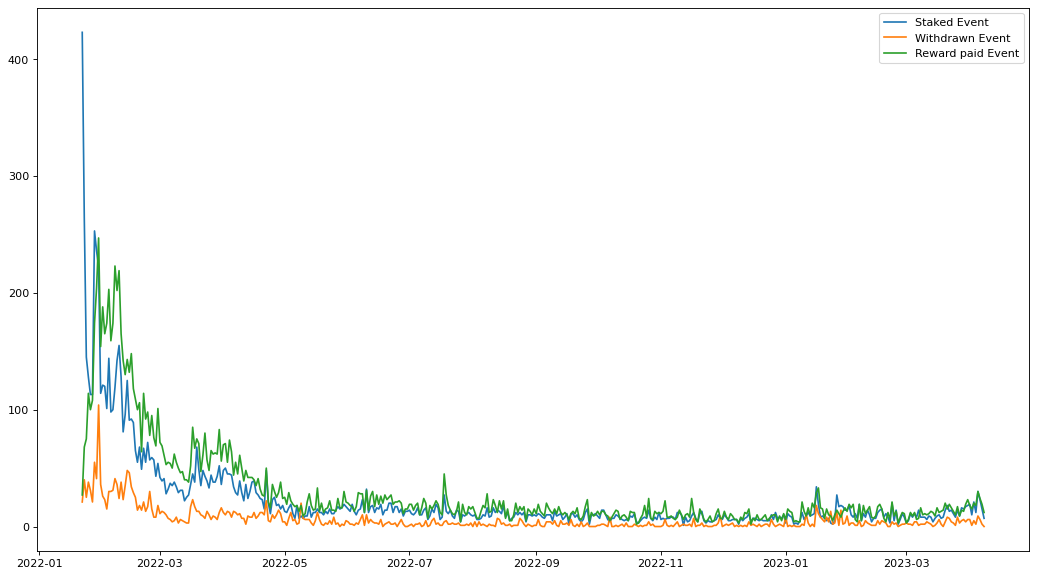

In [41]:
figure(figsize=(16, 9), dpi=80)
plt.plot(interactions_df[['Staking - Staked', 'Staking - Withdrawn', 'Staking - RewardPaid']])
plt.legend(['Staked Event', 'Withdrawn Event', 'Reward paid Event'])
#plt.yscale('log')
plt.show()

In [ ]:
figure(figsize=(16, 9), dpi=80)
plt.plot(interactions_df[['KACY - Approvals', 'aHYPE - Approvals', 'K3C - Approvals']])
plt.title('APPROVALS')
plt.legend(['KACY', 'aHYPE', 'K3C'])
#plt.yscale('log')
plt.show()

In [ ]:
figure(figsize=(16, 9), dpi=80)
plt.plot(interactions_df[['Staking - Staked', 'aHYPE - LogJoin', 'K3C - LogJoin']])
plt.title('INPUTS')
plt.legend(['KACY', 'aHYPE', 'K3C'])
#plt.yscale('log')
plt.show()

In [ ]:
figure(figsize=(16, 9), dpi=80)
plt.plot(interactions_df[['Staking - Withdrawn', 'aHYPE - LogExit', 'K3C - LogExit']])
plt.title('OUTPUTS')
plt.legend(['KACY', 'aHYPE', 'K3C'])
#plt.yscale('log')
plt.show()

In [ ]:
figure(figsize=(16, 9), dpi=300)
plt.plot(interactions_df[['Staking - Staked', 'aHYPE - LogJoin', 'K3C - LogJoin']].values - interactions_df[['Staking - Withdrawn', 'aHYPE - LogExit', 'K3C - LogExit']].values)
plt.title('NET FLOW (INPUTS - OUTPUTS)')
plt.legend(['Staking', 'aHYPE', 'K3C'])
#plt.yscale('log')
plt.show()

In [ ]:
figure(figsize=(16, 9), dpi=300)
plt.plot(interactions_df[['KACY - Transfer to', 'aHYPE - Transfer to', 'K3C - Transfer to']])
plt.title('DAILY TOTAL TRANSACTIONS')
plt.legend(['KACY', 'aHYPE', 'K3C'])
plt.yscale('log')
plt.show()

In [ ]:
contracts_interactions_df = pd.DataFrame()
contracts_interactions_df['Staking'] = staking_interactions_df['wallet']
contracts_interactions_df['aHYPE'] = ahype_token['wallet']
contracts_interactions_df['K3C'] = k3c_token['wallet']
contracts_interactions_df['KACY'] = kacy_token['wallet']

In [ ]:
for row in contracts_interactions_df.columns:
    print(f"Total unique wallets for {row} is: {len(contracts_interactions_df[row].unique())}")

In [ ]:
A = np.ones((contracts_interactions_df.shape[1], contracts_interactions_df.shape[1]))
for i, row in enumerate(contracts_interactions_df.columns):
    for j, column in enumerate(contracts_interactions_df.columns):
        if i!=j:
            A[i,j] = len(set(contracts_interactions_df[row].dropna().unique()).intersection(set(contracts_interactions_df[column].dropna().unique())))/len(contracts_interactions_df[row].dropna().unique())
       

In [ ]:
pessoas_que_interagiram_c_kacy = len(contracts_interactions_df.KACY.dropna().unique())
pessoas_que_interagiram_c_k3c = len(contracts_interactions_df.K3C.dropna().unique())
pessoas_que_interagiram_c_kacy_e_k3c = len(set(contracts_interactions_df.KACY.dropna().unique()).intersection(set(contracts_interactions_df.K3C.dropna().unique())))

# Como ler a tabela abaixo:
print(f"Exemplo: Da galera que mexeu c (a linha) KACY ({pessoas_que_interagiram_c_kacy}), só {pessoas_que_interagiram_c_kacy_e_k3c} ou ~{100*round(pessoas_que_interagiram_c_kacy_e_k3c/pessoas_que_interagiram_c_kacy,2)}% tocaram na (coluna) K3C")
print(f"Por sua vez, quem mexeu c K3C ({pessoas_que_interagiram_c_k3c}), {pessoas_que_interagiram_c_kacy_e_k3c} ou ~{100*round(pessoas_que_interagiram_c_kacy_e_k3c/pessoas_que_interagiram_c_k3c,2)}% tocaram em KACY")
sns.heatmap(pd.DataFrame(A, columns = contracts_interactions_df.columns, index = contracts_interactions_df.columns),
           annot=True)


# Transforming to csv

In [ ]:
kacy_token.to_csv('kacy_interactions.csv')
k3c_token.to_csv('k3c_interactions.csv')
ahype_token.to_csv('ahype_interactions.csv')
staking_interactions_df.to_csv('staking_interactions.csv')